## Vibe Matcher — by Abhishek Anand  
*A fashion recommendation prototype powered by AI embeddings.*

> "Because style isn’t about products — it’s about vibes."

Nexora can use AI to transform shopping from a transactional process into an emotional experience. By understanding users’ moods, preferences, and even social trends, AI can curate hyper-personalized fashion recommendations that feel intuitive and authentic. It enables real-time vibe detection, smarter influencer-content matching, and style generation that adapts to individual personalities. From automating product tagging to building intelligent stylist assistants, AI helps Nexora scale personalization to millions, making every user feel seen, understood, and styled in their own unique way.

In [9]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)


## 1. Data Preparation  



In [2]:
mock_products = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones with light fabric for festival vibes", "tags": ["boho", "festival", "earthy"]},
    {"name": "Urban Jacket", "desc": "Crisp lines, bold details, perfect for energetic city nights", "tags": ["urban", "energetic", "city"]},
    {"name": "Cozy Sweater", "desc": "Soft knit, relaxed fit – your ideal companion for cozy evenings", "tags": ["cozy", "comfort", "home"]},
    {"name": "Minimalist Tee", "desc": "Clean cut, neutral colors – effortless everyday essential", "tags": ["minimal", "everyday", "neutral"]},
    {"name": "Street Sneaker", "desc": "Chunky sole, vibrant accents – streetwear energy redefined", "tags": ["street", "sporty", "bold"]},
    {"name": "Vintage Leather Jacket", "desc": "Worn-in texture, rugged silhouette – timeless rebel energy", "tags": ["vintage", "leather", "rebel"]},
    {"name": "Floral Maxi Skirt", "desc": "Bright blooms and flowy silhouette – a dreamy summer statement", "tags": ["floral", "boho", "summer"]},
    {"name": "Athleisure Leggings", "desc": "Smooth and stretchy for gym sessions or casual coffee runs", "tags": ["athleisure", "fitness", "casual"]},
    {"name": "Classic White Shirt", "desc": "Crisp cotton with a structured form – office to evening elegance", "tags": ["formal", "classic", "elegant"]},
    {"name": "Denim Overalls", "desc": "Relaxed fit and durable denim – playful retro street style", "tags": ["retro", "street", "playful"]},
    {"name": "Satin Slip Dress", "desc": "Silky smooth and minimal – a perfect mix of class and comfort", "tags": ["elegant", "evening", "chic"]},
    {"name": "Cargo Pants", "desc": "Loose fit with side pockets – rugged and functional citywear", "tags": ["urban", "utility", "rugged"]},
    {"name": "Wool Trench Coat", "desc": "Long silhouette in neutral tone – winter sophistication", "tags": ["winter", "formal", "sophisticated"]},
    {"name": "Hooded Windbreaker", "desc": "Lightweight and breathable – sporty style for active days", "tags": ["sporty", "outdoor", "practical"]},
    {"name": "Silk Scarf", "desc": "Soft silk with abstract prints – a touch of artistic elegance", "tags": ["artsy", "chic", "sophisticated"]},
    {"name": "Corduroy Pants", "desc": "Soft texture, vintage cut – earthy tones for fall fashion", "tags": ["vintage", "fall", "cozy"]},
    {"name": "Graphic Hoodie", "desc": "Oversized comfort with bold artwork – expressive streetwear", "tags": ["street", "bold", "casual"]},
    {"name": "Ruffled Blouse", "desc": "Light fabric with delicate details – romantic and airy", "tags": ["romantic", "feminine", "elegant"]},
    {"name": "Puffer Jacket", "desc": "Warm and voluminous – functional design with modern flair", "tags": ["winter", "practical", "urban"]},
    {"name": "Tie-Dye T-Shirt", "desc": "Colorful and relaxed – carefree summer statement piece", "tags": ["boho", "casual", "summer"]}
]

df = pd.DataFrame(mock_products)
df


,name,desc,tags
0,Boho Dress,"Flowy, earthy tones with light fabric for fest...","[boho, festival, earthy]"
1,Urban Jacket,"Crisp lines, bold details, perfect for energet...","[urban, energetic, city]"
2,Cozy Sweater,"Soft knit, relaxed fit – your ideal companion ...","[cozy, comfort, home]"
3,Minimalist Tee,"Clean cut, neutral colors – effortless everyda...","[minimal, everyday, neutral]"
4,Street Sneaker,"Chunky sole, vibrant accents – streetwear ener...","[street, sporty, bold]"
5,Vintage Leather Jacket,"Worn-in texture, rugged silhouette – timeless ...","[vintage, leather, rebel]"
6,Floral Maxi Skirt,Bright blooms and flowy silhouette – a dreamy ...,"[floral, boho, summer]"
7,Athleisure Leggings,Smooth and stretchy for gym sessions or casual...,"[athleisure, fitness, casual]"
8,Classic White Shirt,Crisp cotton with a structured form – office t...,"[formal, classic, elegant]"
9,Denim Overalls,Relaxed fit and durable denim – playful retro ...,"[retro, street, playful]"


In [8]:
model_name = "text-embedding-004"

def embed_text(text, task_type):
    return genai.embed_content(model=model_name, content=text, task_type=task_type)["embedding"]

descs = df["desc"].tolist()
product_embeddings = [embed_text(d, "retrieval_document") for d in descs]

query = "energetic urban chic"
query_embedding = embed_text(query, "retrieval_query")

df["embedding"] = product_embeddings


## 3. Vector Search & Recommendations  



In [6]:
E = np.vstack(df["embedding"].to_numpy())
q = np.array(query_embedding).reshape(1, -1)
sims = cosine_similarity(E, q).ravel()

res = df.copy()
res["score"] = sims
top3 = res.sort_values("score", ascending=False).loc[:, ["name", "tags", "score"]].head(3).reset_index(drop=True)

threshold = 0.5
fallback = None if top3.iloc[0]["score"] >= threshold else "No confident match. Try a more specific vibe (e.g., 'sleek monochrome streetwear')."

display(top3)
print("Fallback:", fallback)


,name,tags,score
0,Urban Jacket,"[urban, energetic, city]",0.678308
1,Street Sneaker,"[street, sporty, bold]",0.620665
2,Denim Overalls,"[retro, street, playful]",0.609685


Fallback: None


## 4. Testing & Evaluation  


,Query,Best Similarity,Good Match?
0,energetic urban chic,0.678308,False
1,cozy indoor comfort,0.603109,False
2,bohemian summer vibe,0.676716,False


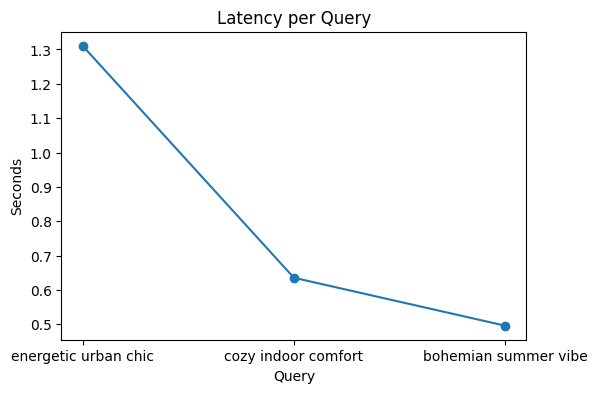

In [7]:
test_queries = [
    "energetic urban chic",
    "cozy indoor comfort",
    "bohemian summer vibe"
]

latencies = []
results = []

for query in test_queries:
    start = time.time()
    q_embed = embed_text(query, "retrieval_query")
    q_vec = np.array(q_embed).reshape(1, -1)
    sims = cosine_similarity(E, q_vec).ravel()
    best_score = float(np.max(sims))
    results.append((query, best_score))
    latencies.append(time.time() - start)

metrics_df = pd.DataFrame(results, columns=["Query", "Best Similarity"])
metrics_df["Good Match?"] = metrics_df["Best Similarity"] > 0.7

display(metrics_df)

plt.figure(figsize=(6, 4))
plt.plot(test_queries, latencies, marker="o")
plt.title("Latency per Query")
plt.ylabel("Seconds")
plt.xlabel("Query")
plt.show()
